In [37]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import os

import pandas as pd  # Used for dealing with the CSV files; has a richer interface than the csv module
import pathlib
import pyproj  # For converting between lon/lat and PS71 + along-track ellipsoidal distance calcuations

import requests  # For downloading index page
from bs4 import BeautifulSoup   # For parsing html and extracting the links


# Ingesting Bedmap data

I plan to base my "unavailable" lines on the bedmap data.

* How to download and display all Bedmap transects?
* How to extract the institution from the bedmap metadata?
* How to associate a bedmap data point/set of points with a transect that I have data for? 

There is a data portal here: https://www.bedmap.scar.org/

And some useful example code here: https://antarctica.github.io/PDC_GeophysicsBook/BEDMAP/Downloading_the_Bedmap_data.html

## Download

* Bedmap 1
  * https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/01619
  * This is one single CSV file
* Bedmap 2
  * https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/01616
  * Separate CSVs for each institution/survey

In [ ]:
# Building on example code from BAS's jupyter notebook, find all URLs that we'd want to download

doi = 'https://doi.org/10.5285/2fd95199-365e-4da1-ae26-3b6d48b3e6ac'  # One of the bedmap landing pages
data_link = 'https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=' + doi.split('/')[-1]
reqs = requests.get(data_link)
soup = BeautifulSoup(reqs.text, 'html.parser')

base_url = 'https://ramadda.data.bas.ac.uk'
prefix = '/repository/entry/get/'

all_urls = [link.get('href') for link in soup.find_all('a')]
download_urls = [base_url + url for url in all_urls if url.startswith(prefix)]
filenames = [url.strip(base_url+prefix).split('?')[0] for url in download_urls]

for ff, uu in zip(filenames, download_urls):
    print("Downloading {} from {}".format(ff, uu))
    
# NB: The actual download is done by download_all_bedmap.sh -- this was just finding the URLs

## Creating QGIS layer

In order for the layer to be not-huge, I want to subsample the datapoints. 500m is tempting, but probably too long; start with 100m.

The fields that I care about are lat, lon, date, time_UTC. 

Assume that if the records are sorted by time they'll also be in order sequentially. (UTIG has had multiple planes in the air at once, but they were integrated into bedmap under KOPRI, PRIC, and UTIG.)

I could try to grab the last point in each line; instead, just always grab the next point when cumulative ellipsoidal distance is greater than the threshold. 

I want 2 levels of organization underneath the top-level import:
* bedmap_data
  * institution
    * project

The filenames are `[institution]_[project]_[AIR|GRN]_BM[2,3].csv`
I plan to collapse bedmap2/3 for the same institution; bedmap1 is special since its points have no metadata.

And it should be possible to turn on/off whole institutions (layer groups?)

It sounds like a QGIS layer needs an underlying data source, so I might as well start with a CSV file.

BAS provided individual shape files for each contributed survey, but they're not enough smaller for me to work from -- I want them subsampled.

In [211]:
# Test with one campaign that I'm familiar with
in_path = "/Volumes/RadarData/BEDMAP/BEDMAP2/UTIG_2008_ICECAP_AIR_BM2.csv"
data = pd.read_csv(in_path, skiprows=18)
print("Memory usage for whole dataset: {}\n".format(data.memory_usage()))
drop_columns = [col for col in data.columns if 'degree' not in col]
data = data.drop(columns=drop_columns)
print("Memory usage for lat/lon dataset: {}".format(data.memory_usage()))

Memory usage for whole dataset: Index                           128
trajectory_id               8582488
trace_number                8582488
longitude (degree_east)     8582488
latitude (degree_north)     8582488
date                        8582488
time_UTC                    8582488
surface_altitude (m)        8582488
land_ice_thickness (m)      8582488
bedrock_altitude (m)        8582488
two_way_travel_time (m)     8582488
aircraft_altitude (m)       8582488
along_track_distance (m)    8582488
dtype: int64

Memory usage for lat/lon dataset: Index                          128
longitude (degree_east)    8582488
latitude (degree_north)    8582488
dtype: int64


#### I want a simple basemap for context....

So grab the ASAID grounding line from Quantarctica3

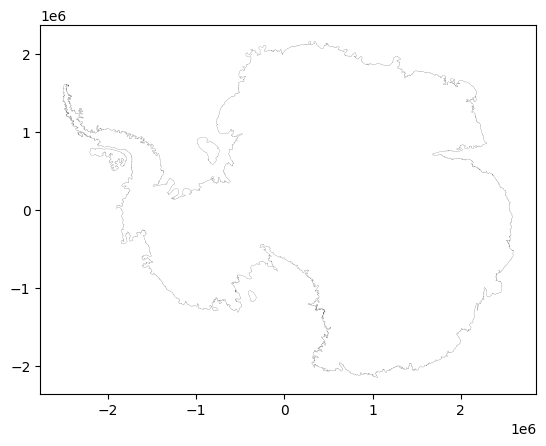

In [2]:
# I want to show individual surveys on an Antarctic basemap for context
# I have the simplified grounding file as part of Quantarctica 
# TODO: This dependency is ugly, and won't work on other computers. Download it separately?
gl_filepath = "/Users/lindzey/ADATA/Quantarctica/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# Example code from https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`
import matplotlib.pyplot as plt

sf = shp.Reader(gl_filepath)

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    plt.plot(x, y, 'k', linewidth=0.1)
plt.show()


In [3]:
# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

### Plotting data from all campaigns

[[]]

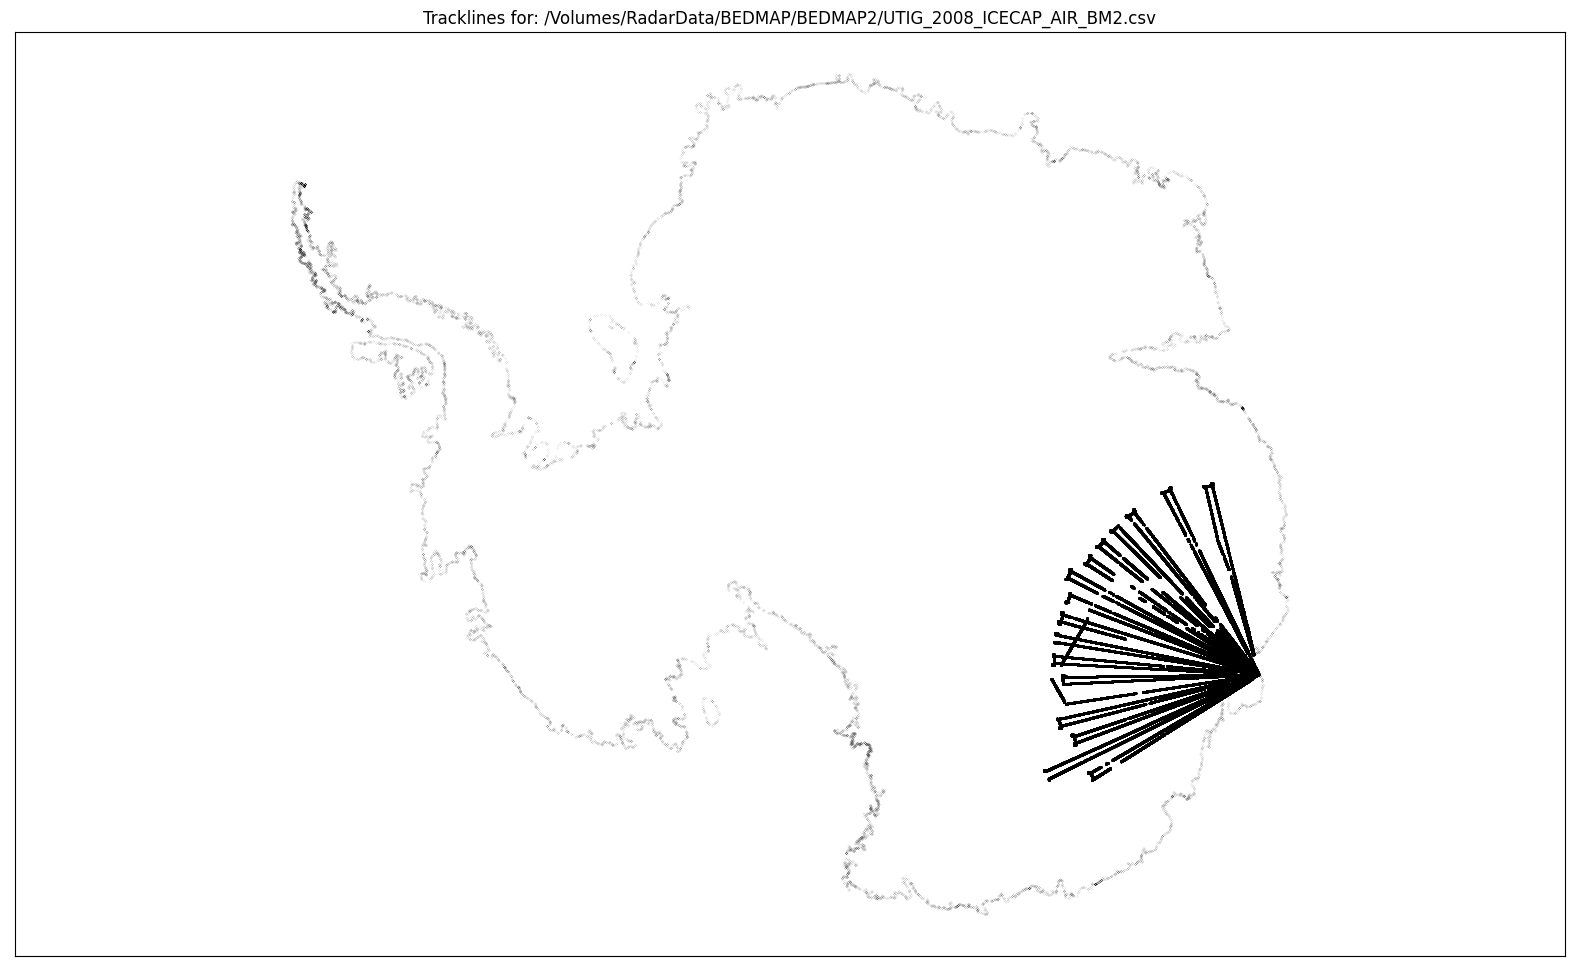

In [5]:
# Let's try plotting a UTIG season
in_path = "/Volumes/RadarData/BEDMAP/BEDMAP2/UTIG_2008_ICECAP_AIR_BM2.csv"
data = pd.read_csv(in_path, skiprows=18)

ps71=pyproj.Proj('epsg:3031')
lon_index = [col for col in data.columns if 'longitude' in col][0]
lat_index = [col for col in data.columns if 'latitude' in col][0]
lon = data[lon_index]
lat = data[lat_index]
xx, yy = ps71.transform(lon, lat)

fig = plt.figure(figsize=(20, 12))
ax1 = fig.subplots(1, 1)

ax1.plot(xx, yy, 'k.', markersize=0.5)
ax1.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
ax1.set_title("Tracklines for: {}".format(in_path))
ax1.axis('equal')
ax1.set(xticks=[])
ax1.set(yticks=[])



# Takeaways from the 2008_ICECAP tracks:
# 1) this is showing bedpicks, NOT tracklines. So, trying to chunk it any farther into flights will probably fail because there are spatial gaps
# 2) It looks like the weird dogleg and diagonal radial may be part of transit flights refueling at DomeC, and presumably reflying a radial of interest

In [6]:
data_dir = "/Volumes/RadarData/BEDMAP"

#### Try to load BEDMAP1 data

[[]]

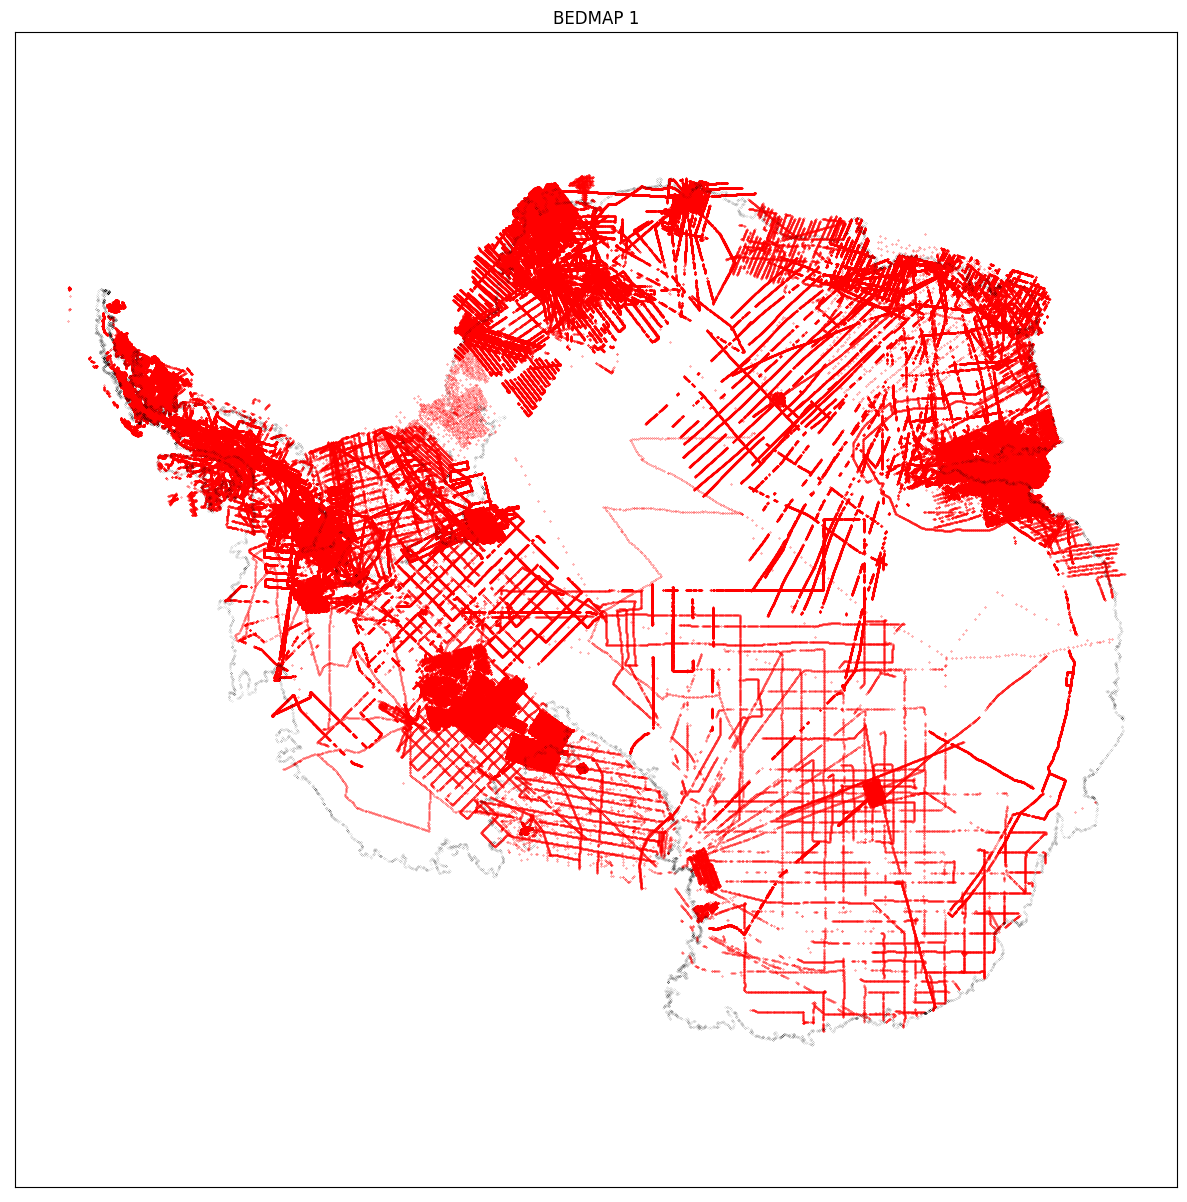

In [7]:
bedmap1_dir = os.path.join(data_dir, "BEDMAP1")
campaigns = [dd for dd in os.listdir(bedmap1_dir) if not dd.startswith('.')]
in_path = os.path.join(bedmap1_dir, campaigns[0])
ps71=pyproj.Proj('epsg:3031')

# First, load the data:
data = pd.read_csv(in_path, skiprows=18)
lon_index = [col for col in data.columns if 'longitude' in col][0]
lat_index = [col for col in data.columns if 'latitude' in col][0]
lon = data[lon_index]
lat = data[lat_index]
xx, yy = ps71.transform(lon, lat)
  
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(1, 1)

    
ax.plot(xx, yy, 'r.', markersize=0.5)
ax.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
ax.set_title("BEDMAP 1")
ax.axis('equal')
ax.set(xticks=[])
ax.set(yticks=[])


#### Plot all BEDMAP2 campaigns; sanity-check geographic locations

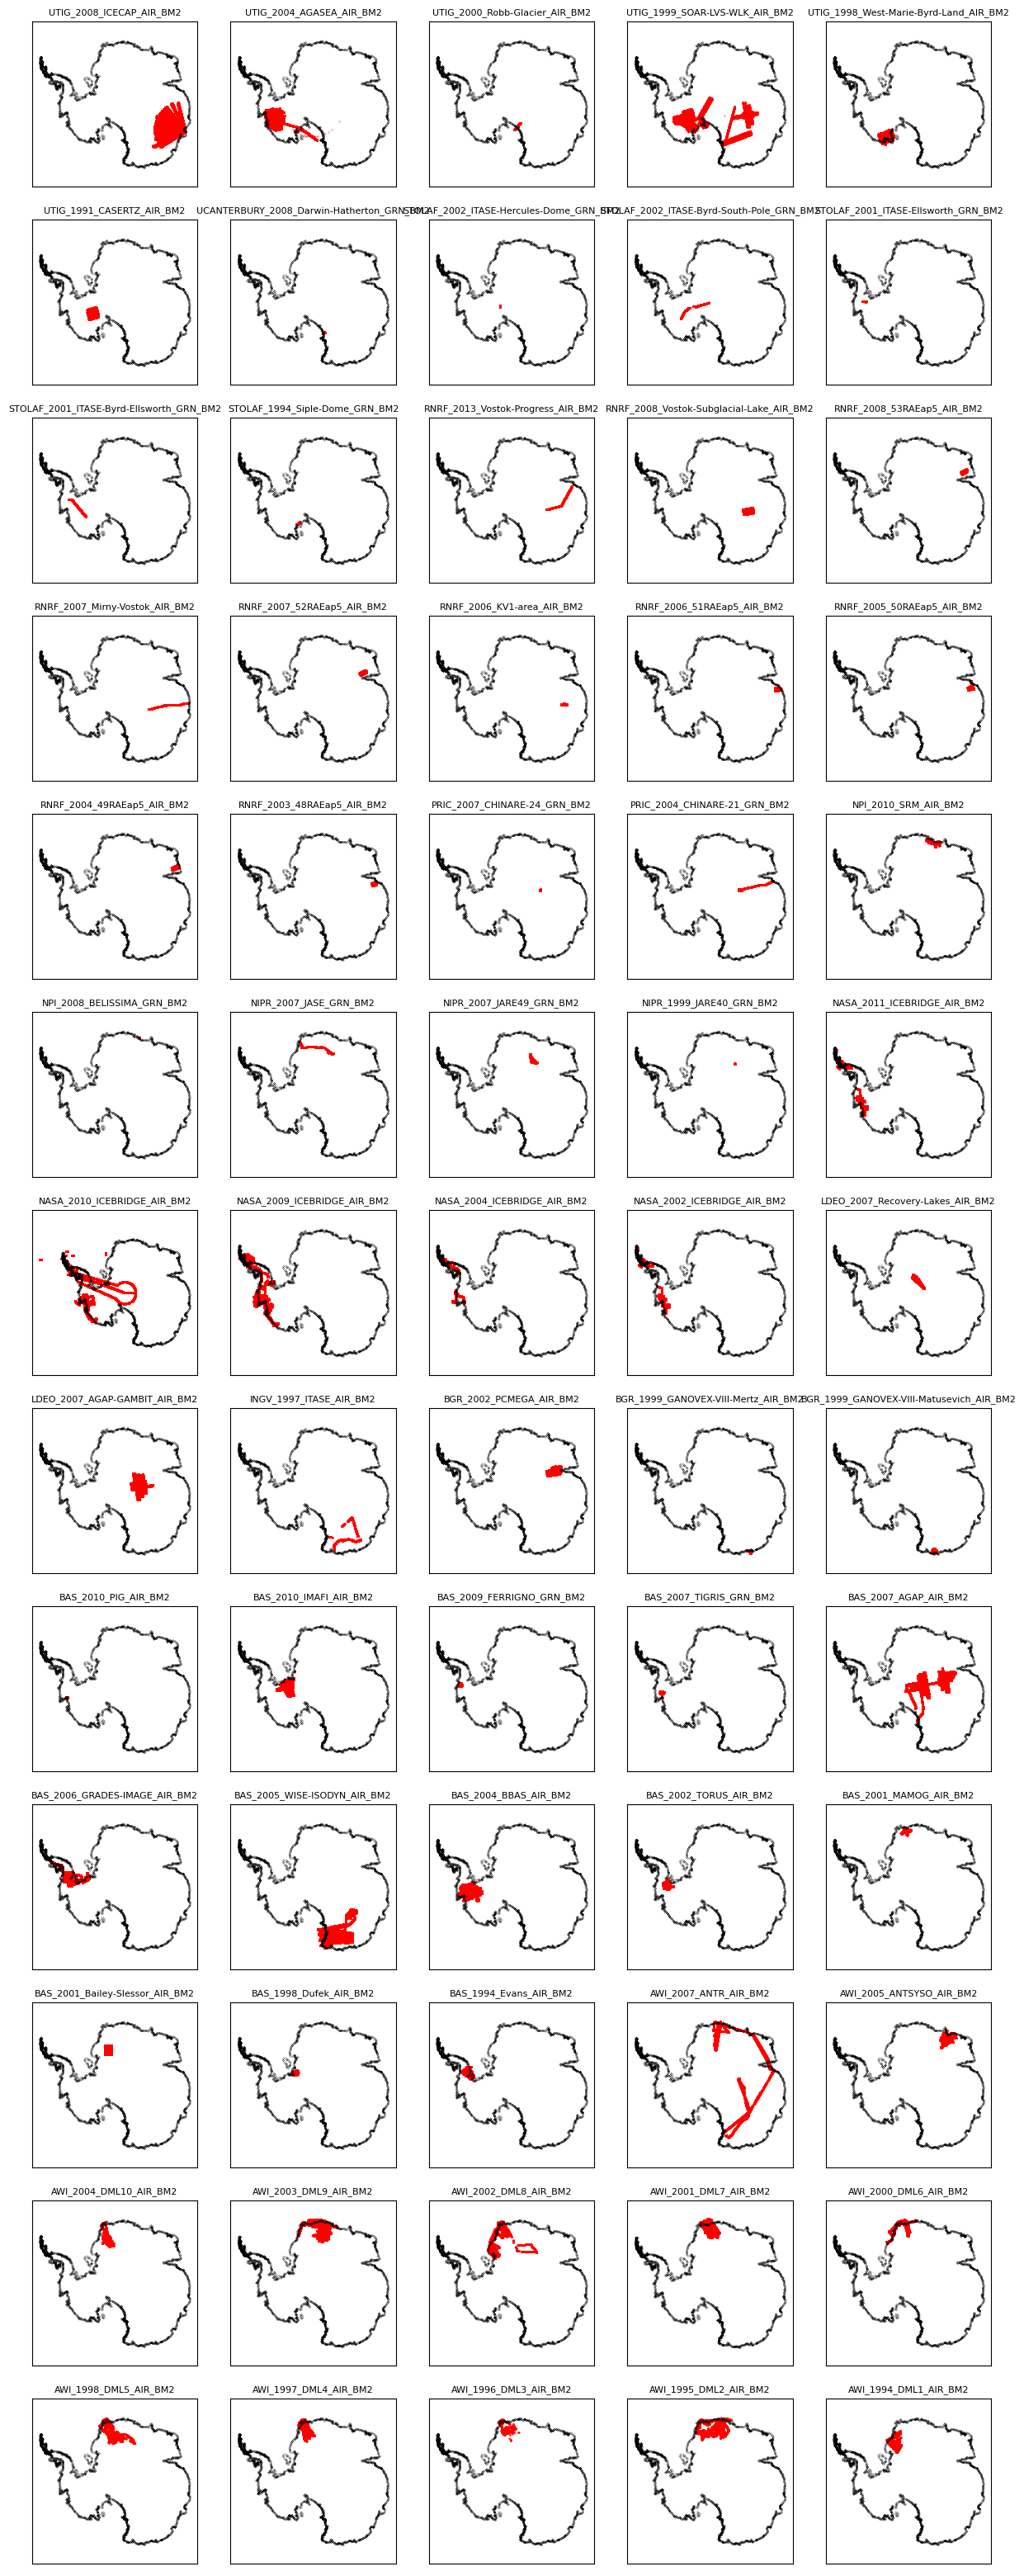

In [8]:
bedmap2_dir = os.path.join(data_dir, "BEDMAP2")
campaigns = [dd for dd in os.listdir(bedmap2_dir) if not dd.startswith('.')]
len(campaigns)

ps71=pyproj.Proj('epsg:3031')

fig = plt.figure(figsize=(15, 40))
nrows = 13
ncols = 5
subplot_axes = fig.subplots(nrows, ncols)

for idx, campaign in enumerate(campaigns):
    in_path = os.path.join(bedmap2_dir, campaign)
    
    # First, load the data:
    data = pd.read_csv(in_path, skiprows=18)
    lon_index = [col for col in data.columns if 'longitude' in col][0]
    lat_index = [col for col in data.columns if 'latitude' in col][0]
    lon = data[lon_index]
    lat = data[lat_index]
    xx, yy = ps71.transform(lon, lat)
    
    col = idx % ncols
    row = int((idx - col)/ncols)
    ax = subplot_axes[row][col]
    
    ax.plot(xx, yy, 'r.', markersize=0.5)
    ax.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
    ax.set_title(campaign.strip('.csv'), fontsize=8)
    ax.axis('equal')
    ax.set(xticks=[])
    ax.set(yticks=[])


#### Plot all BEDMAP3 campaigns; sanity-check geographic locations

/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/2653640141.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(in_path, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/2653640141.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(in_path, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/2653640141.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(in_path, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/2653640141.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(in_path, skiprows=18)
/var/folders/rn/_v8bq9w166j6zdpz3s7f67c40000gn/T/ipykernel_8300/2653640141.py:18: DtypeWarning: Colu

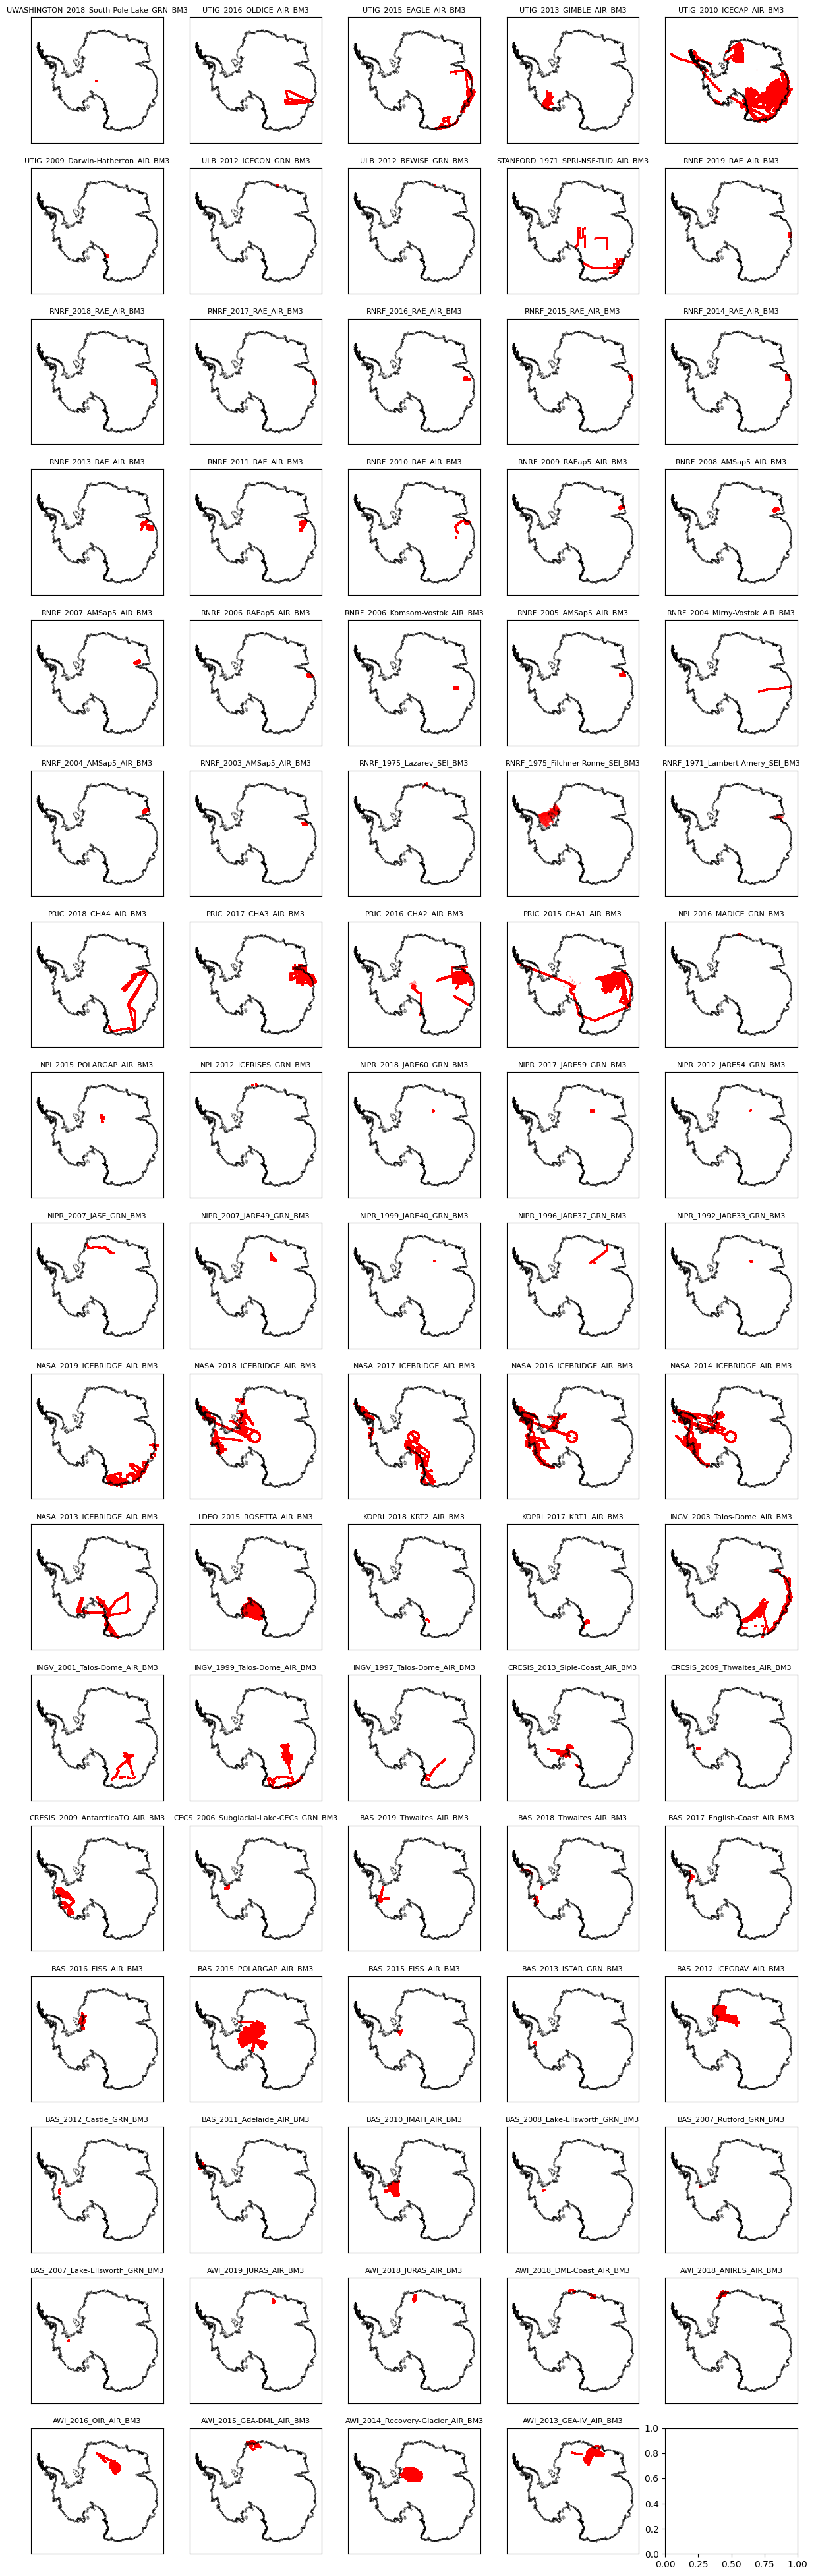

In [9]:
# Yeah  ... lots of copy-paste
data_dir = "/Volumes/RadarData/BEDMAP"
bedmap3_dir = os.path.join(data_dir, "BEDMAP3")
campaigns = [dd for dd in os.listdir(bedmap3_dir) if not dd.startswith('.')]
len(campaigns)

ps71=pyproj.Proj('epsg:3031')

fig = plt.figure(figsize=(15, 50))
nrows = 17
ncols = 5
subplot_axes = fig.subplots(nrows, ncols)

for idx, campaign in enumerate(campaigns):
    in_path = os.path.join(bedmap3_dir, campaign)
    
    # First, load the data:
    data = pd.read_csv(in_path, skiprows=18)
    lon_index = [col for col in data.columns if 'longitude' in col][0]
    lat_index = [col for col in data.columns if 'latitude' in col][0]
    lon = data[lon_index]
    lat = data[lat_index]
    xx, yy = ps71.transform(lon, lat)
    
    col = idx % ncols
    row = int((idx - col)/ncols)
    ax = subplot_axes[row][col]
    
    ax.plot(xx, yy, 'r.', markersize=0.5)
    ax.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
    ax.set_title(campaign.strip('.csv'), fontsize=8)
    ax.axis('equal')
    ax.set(xticks=[])
    ax.set(yticks=[])
